In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score
import xgboost
import lightgbm
import catboost
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
import category_encoders as ce
import pickle


import warnings
warnings.filterwarnings('ignore')

<h1>Load And Explore Train Dataset</h1>

In [2]:
train_loan = pd.read_csv('credit risk train.csv')

In [3]:
train_loan.head()

,loan_amnt,funded_amnt,pymnt_plan,grade,sub_grade_num,short_emp,emp_length_num,home_ownership,dti,purpose,...,delinq_2yrs,delinq_2yrs_zero,inq_last_6mths,last_delinq_none,last_major_derog_none,open_acc,pub_rec,pub_rec_zero,revol_util,bad_loans
0,5000,5000,n,B,0.4,0,11,RENT,27.65,credit_card,...,0.0,1.0,1.0,1,1,3.0,0.0,1.0,83.7,0
1,2400,2400,n,C,1.0,0,11,RENT,8.72,small_business,...,0.0,1.0,2.0,1,1,2.0,0.0,1.0,98.5,0
2,5000,5000,n,A,0.8,0,4,RENT,11.20,wedding,...,0.0,1.0,3.0,1,1,9.0,0.0,1.0,28.3,0
3,3000,3000,n,E,0.2,0,10,RENT,5.35,car,...,0.0,1.0,2.0,1,1,4.0,0.0,1.0,87.5,0
4,5600,5600,n,F,0.4,0,5,OWN,5.55,small_business,...,0.0,1.0,2.0,1,1,11.0,0.0,1.0,32.6,1


<h5 dir='rtl'>
اطلاعات وام:
<br><br>
loan_amnt: مبلغ وام درخواستی
<br><br>
funded_amnt: مبلغ وام تخصیص یافته
<br><br>
pymnt_plan: نوع برنامه پرداخت
<br><br>
grade: رتبه اعتباری 
<br><br>
sub_grade_num: رتبه اعتباری فرعی 
<br><br>
اطلاعات مربوط به وام گیرنده:
<br><br>
short_emp: آیا سابقه شغلی کوتاه مدت دارید؟ 
<br><br>
emp_length_num: مدت زمان اشتغال فعلی (به سال)
<br><br>
home_ownership: وضعیت مالکیت خانه 
<br><br>
dti: نسبت کل بدهی ها به درآمد (درصدی از درآمد که برای پرداخت کل بدهی ها استفاده می شود)
<br><br>
purpose: هدف وام 
<br><br>
payment_inc_ratio: نسبت مبلغ قسط وام به درآمد (درصدی از درآمد که برای پرداخت قسط وام استفاده می شود)
<br><br>
اطلاعات اعتباری:
<br><br>
delinq_2yrs: تعداد دفعاتی که وام‌گیرنده در دو سال گذشته بیش از ۳۰ روز تأخیر در پرداخت داشته است.
<br><br>
delinq_2yrs_zero: آیا تاخیر پرداخت در 2 سال گذشته وجود دارد؟ 
<br><br>
inq_last_6mths: تعداد استعلام های اعتباری در 6 ماه گذشته
<br><br>
last_delinq_none: آیا وام‌گیرنده در تاریخچه اعتباری خود هیچ تأخیری نداشته است؟ 
<br><br>
last_major_derog_none: آیا وام‌گیرنده در تاریخچه اعتباری خود هیچ نشانه بزرگ منفی نداشته است؟ 
<br><br>
open_acc: تعداد حساب های اعتباری باز
<br><br>
pub_rec: تعداد سوابق اعتباری عمومی منفی
<br><br>
pub_rec_zero: آیا وام‌گیرنده سابقه اعتباری عمومی منفی ندارد؟
<br><br>
revol_util: نسبت میزان استفاده از اعتبار
<br><br>
bad_loans: آیا اعطای وام اشتباه است؟ 
</h5>

In [4]:
train_loan.shape

(81738, 21)

In [5]:
train_loan.describe()

,loan_amnt,funded_amnt,sub_grade_num,short_emp,emp_length_num,dti,payment_inc_ratio,delinq_2yrs,delinq_2yrs_zero,inq_last_6mths,last_delinq_none,last_major_derog_none,open_acc,pub_rec,pub_rec_zero,revol_util,bad_loans
count,81738.000000,81738.000000,81738.000000,81738.000000,81738.000000,81738.000000,81737.000000,81722.000000,81722.000000,81722.000000,81738.000000,81738.000000,81722.000000,81722.000000,81722.000000,81738.000000,81738.000000
mean,12810.487166,12735.070591,0.598116,0.123027,6.381756,15.496182,7.555679,0.210837,0.858471,0.982710,0.589163,0.874709,10.459007,0.104366,0.907528,53.790952,0.189288
std,7936.485839,7888.874254,0.278611,0.328470,3.735226,7.489666,4.124174,0.660849,0.348568,1.260642,0.491989,0.331050,4.731931,0.361557,0.289693,25.755135,0.391739
min,500.000000,500.000000,0.200000,0.000000,0.000000,0.000000,0.028895,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6625.000000,6600.000000,0.400000,0.000000,3.000000,9.880000,4.356000,0.000000,1.000000,0.000000,0.000000,1.000000,7.000000,0.000000,1.000000,34.800000,0.000000
50%,11000.000000,10950.000000,0.600000,0.000000,6.000000,15.270000,6.953560,0.000000,1.000000,1.000000,1.000000,1.000000,10.000000,0.000000,1.000000,55.800000,0.000000
75%,17600.000000,17475.000000,0.800000,0.000000,11.000000,20.840000,10.206200,0.000000,1.000000,2.000000,1.000000,1.000000,13.000000,0.000000,1.000000,74.500000,0.000000
max,35000.000000,35000.000000,1.000000,1.000000,11.000000,39.880000,54.171000,29.000000,1.000000,32.000000,1.000000,1.000000,76.000000,11.000000,1.000000,150.700000,1.000000


In [6]:
train_loan.describe(include='object')

,pymnt_plan,grade,home_ownership,purpose
count,81738,81738,81738,81738
unique,1,7,4,12
top,n,B,MORTGAGE,debt_consolidation
freq,81738,24775,39583,45428


In [7]:
train_loan.isnull().sum()

loan_amnt                 0
funded_amnt               0
pymnt_plan                0
grade                     0
sub_grade_num             0
short_emp                 0
emp_length_num            0
home_ownership            0
dti                       0
purpose                   0
payment_inc_ratio         1
delinq_2yrs              16
delinq_2yrs_zero         16
inq_last_6mths           16
last_delinq_none          0
last_major_derog_none     0
open_acc                 16
pub_rec                  16
pub_rec_zero             16
revol_util                0
bad_loans                 0
dtype: int64

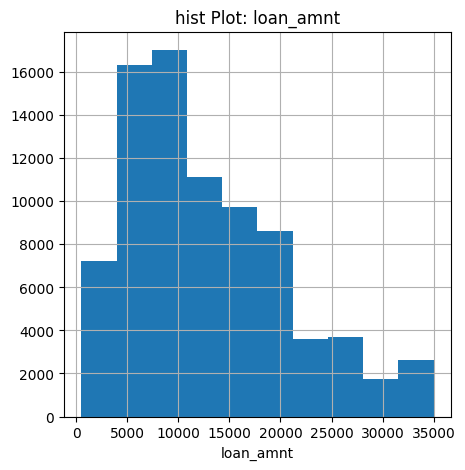

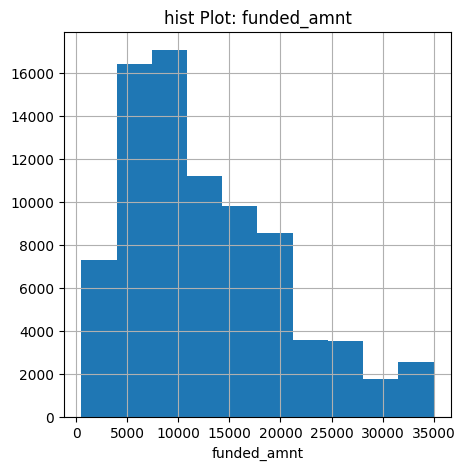

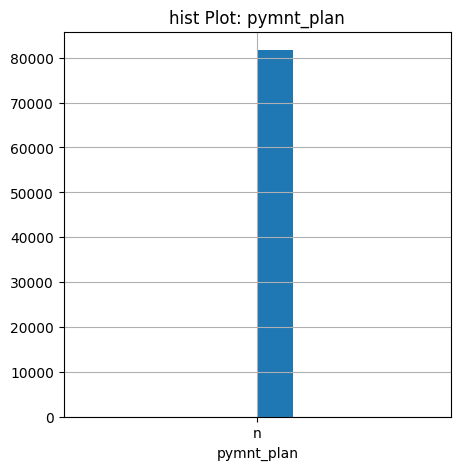

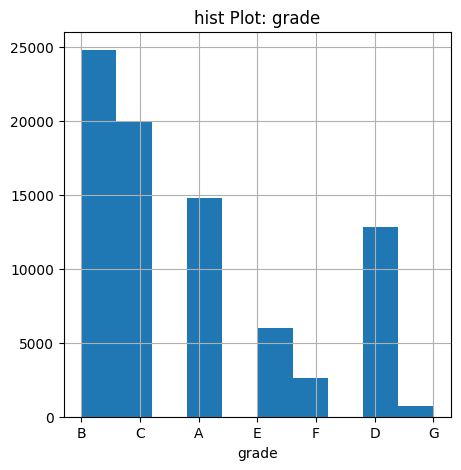

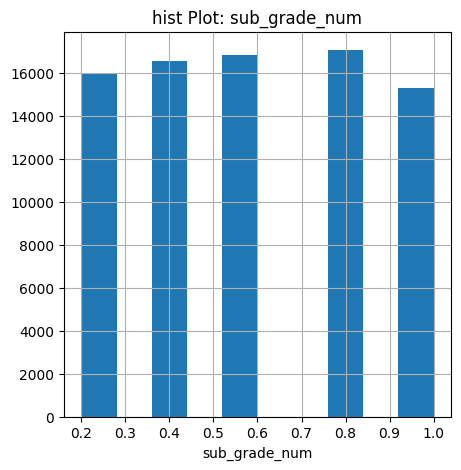

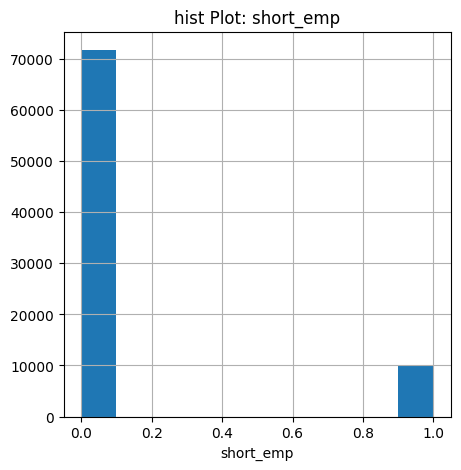

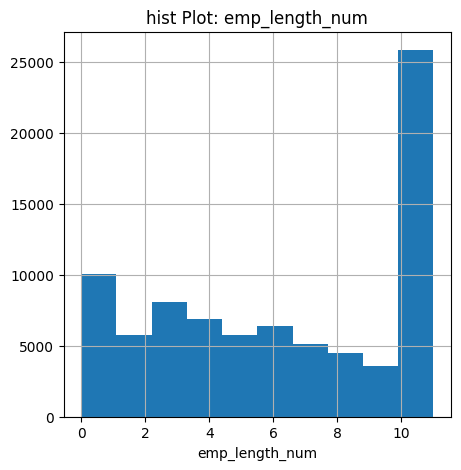

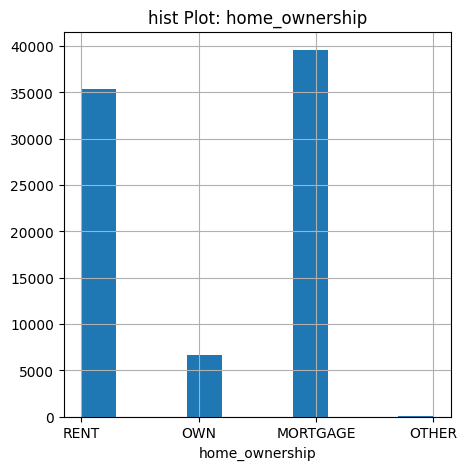

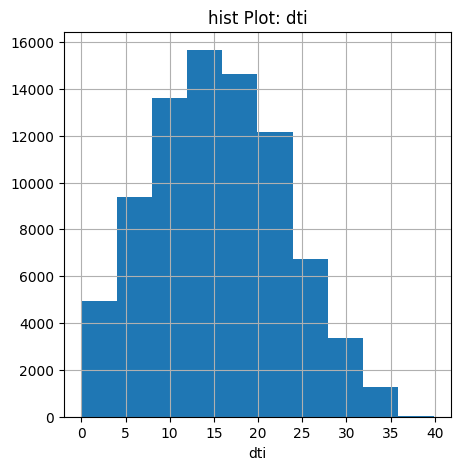

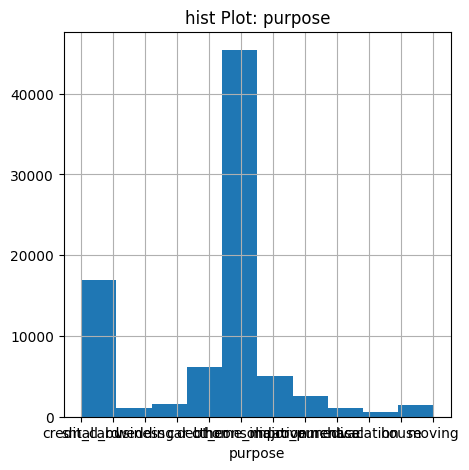

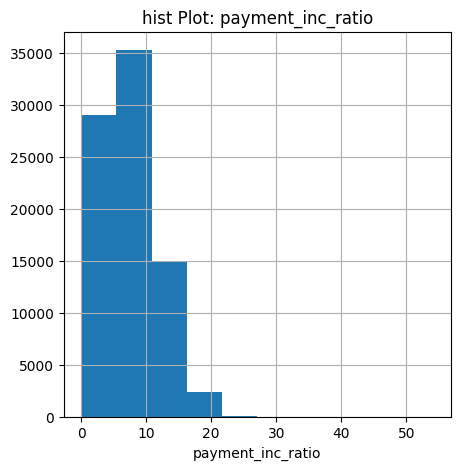

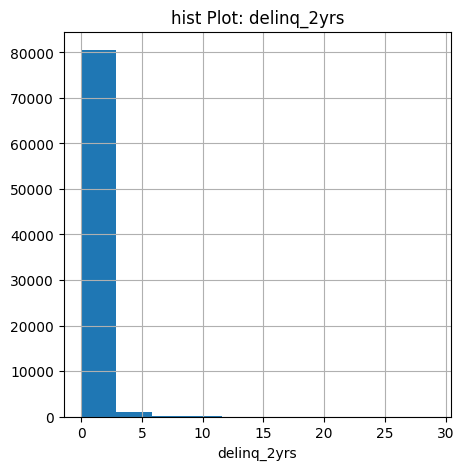

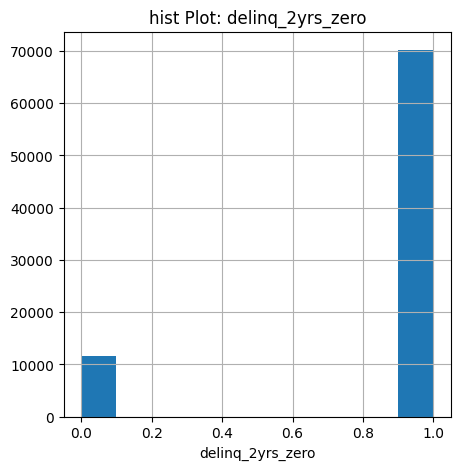

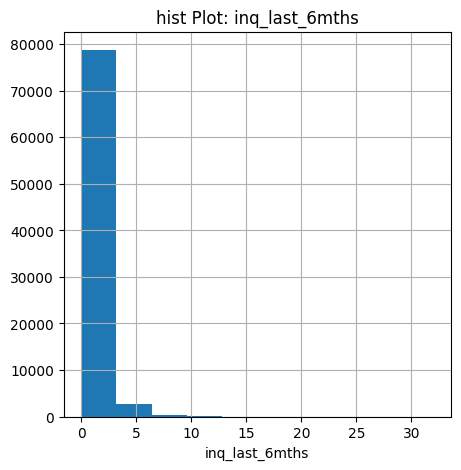

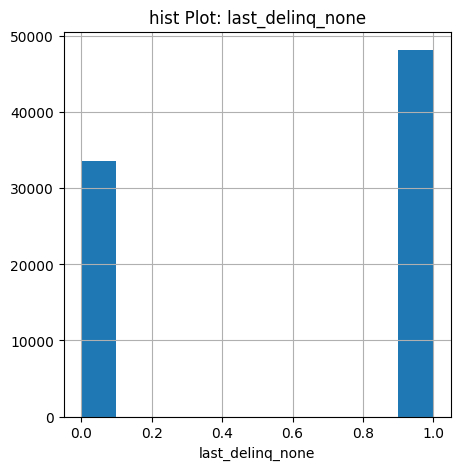

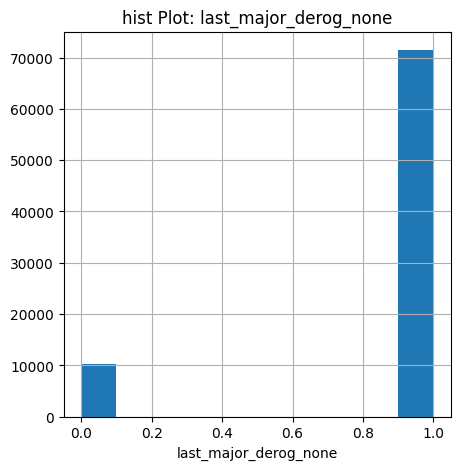

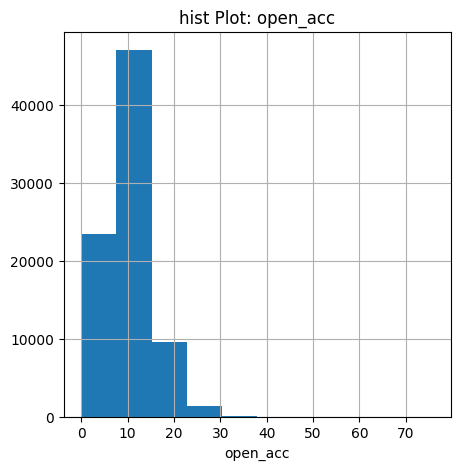

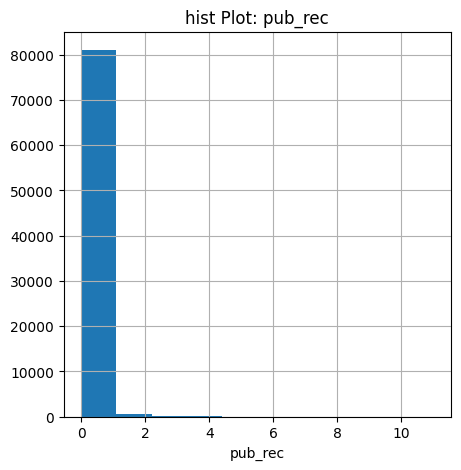

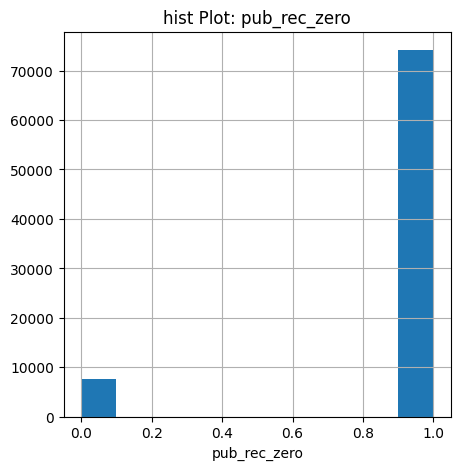

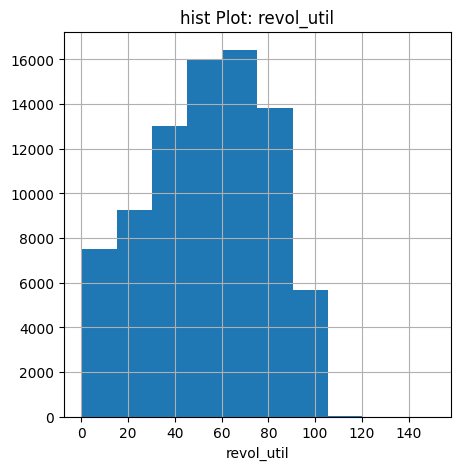

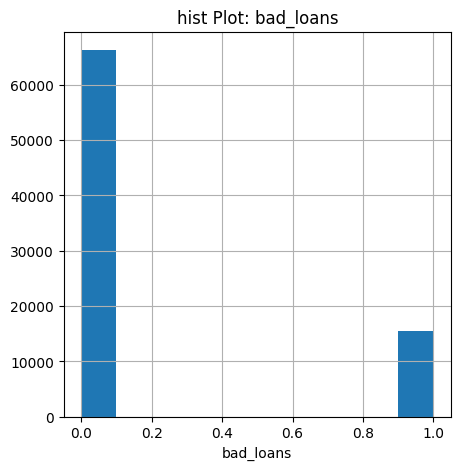

In [8]:
columns = train_loan.columns
for column in columns:
    plt.figure(figsize=(5, 5))
    plt.hist(train_loan[column])
    plt.title(f'hist Plot: {column}')
    plt.xlabel(column)
    plt.grid(True)
    plt.show()

<Axes: >

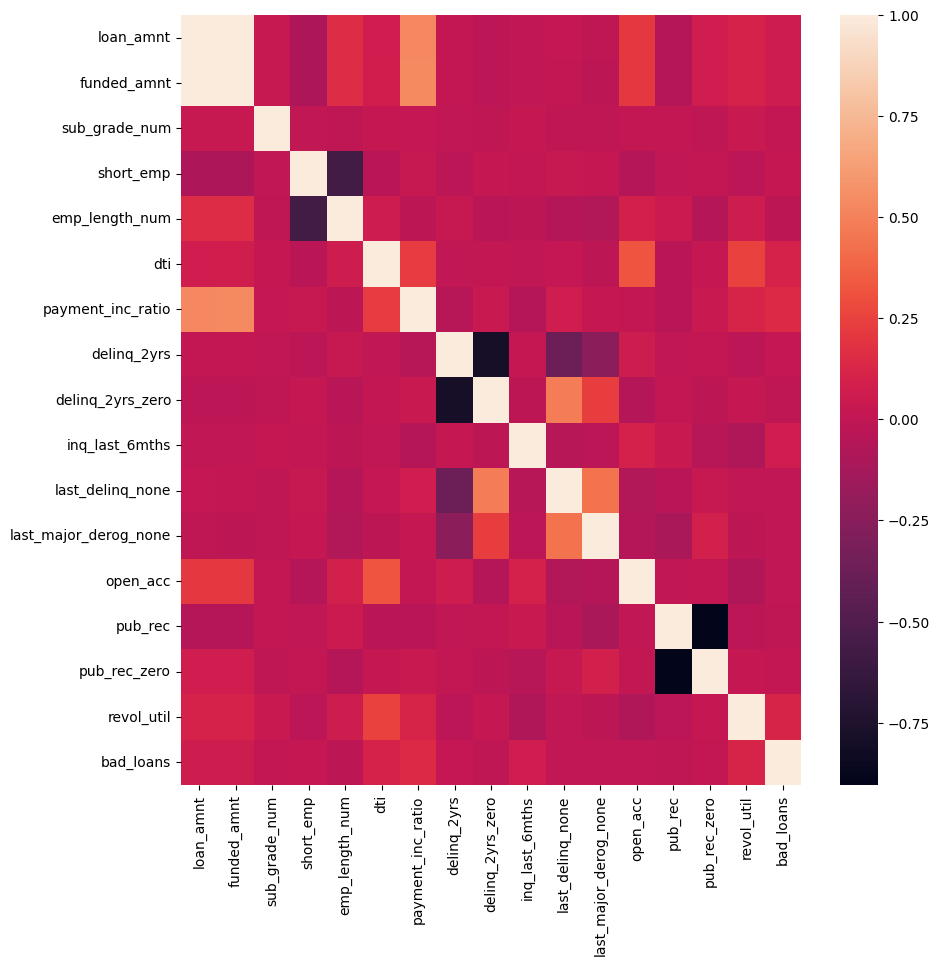

In [9]:
plt.figure(figsize=(10,10))
cor = train_loan.loc[:, train_loan.columns[train_loan.dtypes != 'object']].corr()
sns.heatmap(cor)

In [10]:
cor

,loan_amnt,funded_amnt,sub_grade_num,short_emp,emp_length_num,dti,payment_inc_ratio,delinq_2yrs,delinq_2yrs_zero,inq_last_6mths,last_delinq_none,last_major_derog_none,open_acc,pub_rec,pub_rec_zero,revol_util,bad_loans
loan_amnt,1.000000,0.995312,0.030203,-0.087332,0.154180,0.068647,0.530500,0.008831,-0.019839,-0.001295,0.010870,-0.011505,0.205120,-0.056791,0.065767,0.102248,0.059492
funded_amnt,0.995312,1.000000,0.028183,-0.087384,0.155082,0.071137,0.537443,0.010070,-0.021138,-0.001961,0.009125,-0.015141,0.206620,-0.056094,0.065216,0.104979,0.058492
sub_grade_num,0.030203,0.028183,1.000000,0.001544,-0.005008,0.018557,0.015532,0.002798,-0.004269,0.021765,-0.010128,-0.006963,0.004293,0.006218,-0.006514,0.035868,0.005958
short_emp,-0.087332,-0.087384,0.001544,1.000000,-0.566570,-0.028191,0.029014,-0.019606,0.019087,0.005223,0.030084,0.025306,-0.058491,-0.002809,0.004476,-0.022508,0.021918
emp_length_num,0.154180,0.155082,-0.005008,-0.566570,1.000000,0.058684,-0.015312,0.027017,-0.036929,-0.015966,-0.052882,-0.065938,0.085196,0.045618,-0.052025,0.058048,-0.012019
dti,0.068647,0.071137,0.018557,-0.028191,0.058684,1.000000,0.226372,-0.001902,0.005367,-0.001225,0.015491,-0.019056,0.321011,-0.026541,0.025430,0.254992,0.106921
payment_inc_ratio,0.530500,0.537443,0.015532,0.029014,-0.015312,0.226372,1.000000,-0.042228,0.037421,-0.052386,0.067793,0.021595,0.004047,-0.040033,0.039290,0.111467,0.142037
delinq_2yrs,0.008831,0.010070,0.002798,-0.019606,0.027017,-0.001902,-0.042228,1.000000,-0.785756,0.020812,-0.378570,-0.227899,0.057110,0.002293,0.005196,-0.020829,0.013288
delinq_2yrs_zero,-0.019839,-0.021138,-0.004269,0.019087,-0.036929,0.005367,0.037421,-0.785756,1.000000,-0.013840,0.483652,0.227509,-0.052890,0.007874,-0.011698,0.023202,-0.010252
inq_last_6mths,-0.001295,-0.001961,0.021765,0.005223,-0.015966,-0.001225,-0.052386,0.020812,-0.013840,1.000000,-0.048802,-0.025568,0.097491,0.040337,-0.042509,-0.084998,0.069216


In [11]:
X = train_loan.drop(columns='bad_loans')
y = train_loan.bad_loans

In [12]:
y.value_counts()   # Imbalance Data

bad_loans
0    66266
1    15472
Name: count, dtype: int64

In [13]:
# drop columns with collinearity
X.drop(columns=['funded_amnt', 'delinq_2yrs_zero', 'pub_rec'], inplace=True)

In [14]:
# pymnt_plan has only one value
X.drop(columns='pymnt_plan', inplace=True)

In [15]:
X.select_dtypes(include=['object']).columns

Index(['grade', 'home_ownership', 'purpose'], dtype='object')

In [16]:
# change 'object' types to 'category'
cat_features = list(X.select_dtypes(include=['object']).columns)
X[cat_features] = X[cat_features].astype('category')

<h1>Encodeing</h1>

In [17]:
# encode categorical columns
cat_features = list(X.select_dtypes(include=['category']).columns)
encoder = ce.TargetEncoder(cols=cat_features)
encoder.fit(X[cat_features], y)
X_enc = pd.concat([X, encoder.transform(X[cat_features]).add_suffix('_enc')], axis=1)
X_enc.drop(columns=['grade', 'home_ownership', 'purpose'], inplace=True)

<h1>Handling Missing Value</h1>

In [18]:
X_enc_imp = X_enc.copy()

X_enc_imp.payment_inc_ratio.fillna(0, inplace=True)
X_enc_imp.fillna(-1, inplace=True)

X_enc_imp.payment_inc_ratio.fillna(0, inplace=True)
X_enc_imp.fillna(-1, inplace=True)

<h1>Train Test Split</h1>

In [19]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_enc_imp, y, stratify=y, test_size=0.3)
Xtest, Xvalid, ytest, yvalid =  train_test_split(Xtest, ytest, stratify=ytest, test_size=0.5)

<h1>Handling Outliers</h1>

In [20]:
# Log Transform
########### train #############
Xtrain_log = Xtrain.copy()
cols = ['payment_inc_ratio', 'open_acc']
for c in cols:
    Xtrain_log[c] = np.log(Xtrain_log[c] + 1.1)

########### valid #############
Xvalid_log = Xvalid.copy()
cols = ['payment_inc_ratio', 'open_acc']
for c in cols:
    Xvalid_log[c] = np.log(Xvalid_log[c] + 1.1)

########### test #############
Xtest_log = Xtest.copy()
cols = ['payment_inc_ratio', 'open_acc']
for c in cols:
    Xtest_log[c] = np.log(Xtest_log[c] + 1.1)

In [21]:
# z-score outlier detection
########### train #############
Xtrain_clip = Xtrain.copy()
columns = ['loan_amnt', 'sub_grade_num', 'emp_length_num', 'dti', 'delinq_2yrs',
           'inq_last_6mths', 'revol_util', 'payment_inc_ratio', 'open_acc']

for c in columns:
    if (Xtrain_clip[c].dtypes == int) | (Xtrain_clip[c].dtypes == float):
        L = Xtrain[c].mean() - 3*Xtrain[c].std()
        U = Xtrain[c].mean() + 3*Xtrain[c].std()
        Xtrain_clip[c] = Xtrain_clip[c].clip(L,U)

########### valid #############
Xvalid_clip = Xvalid.copy()
columns = ['loan_amnt', 'sub_grade_num', 'emp_length_num', 'dti', 'delinq_2yrs',
           'inq_last_6mths', 'revol_util', 'payment_inc_ratio', 'open_acc']

for c in columns:
    if (Xvalid_clip[c].dtypes == int) | (Xvalid_clip[c].dtypes == float):
        L = Xtrain[c].mean() - 3*Xtrain[c].std()
        U = Xtrain[c].mean() + 3*Xtrain[c].std()
        Xvalid_clip[c] =Xvalid_clip[c].clip(L,U)

########### test #############
Xtest_clip = Xtest.copy()
columns = ['loan_amnt', 'sub_grade_num', 'emp_length_num', 'dti', 'delinq_2yrs',
           'inq_last_6mths', 'revol_util', 'payment_inc_ratio', 'open_acc']

for c in columns:
    if (Xtest_clip[c].dtypes == int) | (Xtest_clip[c].dtypes == float):
        L = Xtrain[c].mean() - 3*Xtrain[c].std()
        U = Xtrain[c].mean() + 3*Xtrain[c].std()
        Xtest_clip[c] =Xtest_clip[c].clip(L,U)

<h1>Normalization With MinMaxScaler</h1>

In [22]:
# Normalization
mmscaler = MinMaxScaler()

Xtrain_log_normal = mmscaler.fit_transform(Xtrain_log)
Xtrain_log_normal = pd.DataFrame(Xtrain_log_normal, columns=Xtrain_log.columns, index=Xtrain_log.index)

Xvalid_log_normal = mmscaler.transform(Xvalid_log)
Xvalid_log_normal = pd.DataFrame(Xvalid_log_normal, columns=Xvalid_log.columns, index=Xvalid_log.index)

Xtest_log_normal = mmscaler.transform(Xtest_log)
Xtest_log_normal = pd.DataFrame(Xtest_log_normal, columns=Xtest_log.columns, index=Xtest_log.index)

#############################
Xtrain_clip_normal = mmscaler.fit_transform(Xtrain_clip)
Xtrain_clip_normal = pd.DataFrame(Xtrain_clip_normal, columns=Xtrain_clip.columns, index=Xtrain_clip.index)

Xvalid_clip_normal = mmscaler.transform(Xvalid_clip)
Xvalid_clip_normal = pd.DataFrame(Xvalid_clip_normal, columns=Xvalid_clip.columns, index=Xvalid_clip.index)

Xtest_clip_normal = mmscaler.transform(Xtest_clip)
Xtest_clip_normal = pd.DataFrame(Xtest_clip_normal, columns=Xtest_clip.columns, index=Xtest_clip.index)

<h1>Under-Sampling</h1>

In [23]:
# Under-Sampling
under_sampler = RandomUnderSampler()

Xtrain_under, ytrain_under = under_sampler.fit_resample(Xtrain, ytrain)
Xtrain_log_normal_under, ytrain_log_normal_under = under_sampler.fit_resample(Xtrain_log_normal, ytrain)
Xtrain_clip_normal_under, ytrain_clip_normal_under = under_sampler.fit_resample(Xtrain_clip_normal, ytrain)

<h1>PCA</h1>

In [24]:
# PCA with Under Sampled Data
from sklearn.decomposition import PCA
pca = PCA(n_components=0.99)

Xtrain_pca = pd.DataFrame(pca.fit_transform(Xtrain_under), index=Xtrain_under.index)
Xtrain_under_pca = pd.concat([Xtrain_under, Xtrain_pca], axis=1)
Xtrain_under_pca.columns=Xtrain_under_pca.columns.astype(str)

Xvalid_pca = pd.DataFrame(pca.transform(Xvalid), index=Xvalid.index)
Xvalid_pca = pd.concat([Xvalid, Xvalid_pca], axis=1)
Xvalid_pca.columns = Xvalid_pca.columns.astype(str)

Xtest_pca = pd.DataFrame(pca.transform(Xtest), index=Xtest.index)
Xtest_pca = pd.concat([Xtest, Xtest_pca], axis=1)
Xtest_pca.columns = Xtest_pca.columns.astype(str)

# ###########################################
Xtrain_clip_normal_pca = pd.DataFrame(pca.fit_transform(Xtrain_clip_normal_under), index=Xtrain_clip_normal_under.index)
Xtrain_clip_normal_under_pca = pd.concat([Xtrain_clip_normal_under, Xtrain_clip_normal_pca], axis=1)
Xtrain_clip_normal_under_pca.columns=Xtrain_clip_normal_under_pca.columns.astype(str)

Xvalid_clip_normal_pca = pd.DataFrame(pca.transform(Xvalid_clip_normal), index=Xvalid_clip_normal.index)
Xvalid_clip_normal_pca = pd.concat([Xvalid_clip_normal, Xvalid_clip_normal_pca], axis=1)
Xvalid_clip_normal_pca.columns=Xvalid_clip_normal_pca.columns.astype(str)

Xtest_clip_normal_pca = pd.DataFrame(pca.transform(Xtest_clip_normal), index=Xtest_clip_normal.index)
Xtest_clip_normal_pca = pd.concat([Xtest_clip_normal, Xtest_clip_normal_pca], axis=1)
Xtest_clip_normal_pca.columns=Xtest_clip_normal_pca.columns.astype(str)


<h1>Best Models</h1>

<h2>XGBoost</h2>

In [25]:
params = {'n_estimators': 3000, 'missing': np.nan, 'verbosity': 0, 'scale_pos_weight': 4.3,
          'max_depth': 3, 'colsample_bytree': 0.75, 'learning_rate': 0.08057545858414107, 
          'reg_alpha': 5.0, 'reg_lambda': 0.5, 'subsample': 0.5318325637625425, 'min_child_weight': 16}

xgbln = xgboost.XGBClassifier(**params)
xgbln.fit(Xtrain_log_normal, ytrain, 
        eval_set=[(Xtrain_log_normal, ytrain), (Xvalid_log_normal, yvalid)], 
        early_stopping_rounds=10, verbose=0)
xgbln_pred = xgbln.predict(Xtest_log_normal)

print('XGBoost result: ', f1_score(y_true=ytest, y_pred=xgbln_pred))

XGBoost result:  0.39994720168954595


<h2>LightGBM</h2>

In [26]:
params = {'n_estimators': 5000, 'objective': 'binary', 'metric': 'binary_logloss', 'verbosity': -1,
          'boosting_type': 'gbdt', 'early_stopping_rounds': 10,'class_weight': 'balanced',
          'max_depth': 3, 'num_leaves': 782, 'colsample_bytree': 0.5, 'learning_rate': 0.0022003317562072694, 
          'reg_alpha': 1.0, 'reg_lambda': 3.0, 'subsample': 0.3940411021541431, 'min_child_samples': 93}

lgb = lightgbm.LGBMClassifier(**params)
lgb.fit(Xtrain, ytrain, 
        eval_set=[(Xtrain, ytrain), (Xvalid, yvalid)])
lgb_pred = lgb.predict(Xtest)
print('LightGBM result: ', f1_score(y_true=ytest, y_pred=lgb_pred))

LightGBM result:  0.3995256292001581


<h2>CatBoost</h2>

In [27]:
params = {'iterations': 100, 'verbose': 0, 'od_type': 'IncToDec', 'od_wait': 10, 'boosting_type': 'Plain',
          'leaf_estimation_method': 'Newton', 'class_weights': {0:0.2, 1:0.8},
          'depth': 7, 'learning_rate': 0.10532310426567097, 'l2_leaf_reg': 3.0, 'subsample': 0.5940099292935849}

ctb = catboost.CatBoostClassifier(**params)
ctb.fit(Xtrain, ytrain, 
        eval_set=[(Xtrain, ytrain), (Xvalid, yvalid)])
ctb_pred = ctb.predict(Xtest)

print('Catboost result: ', f1_score(y_true=ytest, y_pred=ctb_pred))

Catboost result:  0.4036178631995478


<h2>MLP</h2>

In [28]:
mlpcnup = Sequential()

# input layer
mlpcnup.add(Input(shape=(int(Xtrain_clip_normal_under_pca.shape[1]),)))

# hidden layers
mlpcnup.add(Dense(units=49, activation='relu'))
mlpcnup.add(Dense(units=20, activation='relu'))
mlpcnup.add(Dense(units=35, activation='relu'))

# Output layer
mlpcnup.add(Dense(1, activation='sigmoid'))

mlpcnup.compile(optimizer=Adam(learning_rate=0.002002357043019399), loss='binary_crossentropy')
mlpcnup.fit(Xtrain_clip_normal_under_pca, ytrain_under, epochs=100, batch_size=10000, verbose=0, 
            validation_data=(Xvalid_clip_normal_pca, yvalid))

mlp_pred = mlpcnup.predict(Xtest_clip_normal_pca)
mlp_pred = (mlp_pred > 0.5).astype(int)

print('Keras MLP result: ', f1_score(y_true=ytest, y_pred=mlp_pred))

384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Keras MLP result:  0.3972298445054227


<h1>Train Best Models With All Train Data And Predict Test Data</h1>

In [29]:
test_loan = pd.read_csv('credit risk test.csv')

In [30]:
test_set = test_loan.copy()
test_set.drop(columns=['funded_amnt', 'delinq_2yrs_zero', 'pub_rec'], inplace=True)
test_set.drop(columns='pymnt_plan', inplace=True)

In [31]:
# encode categorical columns
test_set_enc = pd.concat([test_set, encoder.transform(test_set[cat_features]).add_suffix('_enc')], axis=1)
test_set_enc.drop(columns=['grade', 'home_ownership', 'purpose'], inplace=True)

In [32]:
test_set_enc_imp = test_set_enc.copy()

test_set_enc_imp.payment_inc_ratio.fillna(0, inplace=True)
test_set_enc_imp.fillna(-1, inplace=True)

test_set_enc_imp.payment_inc_ratio.fillna(0, inplace=True)
test_set_enc_imp.fillna(-1, inplace=True)

In [33]:
# Log Transform
########## train set ##########
X_log = X_enc_imp.copy()
cols = ['payment_inc_ratio', 'open_acc']
for c in cols:
    X_log[c] = np.log(X_log[c] + 1.1)

########## test set ##########
test_set_log = test_set_enc_imp.copy()
cols = ['payment_inc_ratio', 'open_acc']
for c in cols:
    test_set_log[c] = np.log(test_set_log[c] + 1.1)

In [34]:
# z-score outlier detection
########## train set ##########
X_clip = X_enc_imp.copy()
columns = ['loan_amnt', 'sub_grade_num', 'emp_length_num', 'dti', 'delinq_2yrs',
           'inq_last_6mths', 'revol_util', 'payment_inc_ratio', 'open_acc']

for c in columns:
    if (X_clip[c].dtypes == int) | (X_clip[c].dtypes == float):
        L = X_enc_imp[c].mean() - 3*X_enc_imp[c].std()
        U = X_enc_imp[c].mean() + 3*X_enc_imp[c].std()
        X_clip[c] = X_clip[c].clip(L,U)

########## test set ##########
test_set_clip = test_set_enc_imp.copy()
columns = ['loan_amnt', 'sub_grade_num', 'emp_length_num', 'dti', 'delinq_2yrs',
           'inq_last_6mths', 'revol_util', 'payment_inc_ratio', 'open_acc']

for c in columns:
    if (test_set_clip[c].dtypes == int) | (test_set_clip[c].dtypes == float):
        L = X_enc_imp[c].mean() - 3*X_enc_imp[c].std()
        U = X_enc_imp[c].mean() + 3*X_enc_imp[c].std()
        test_set_clip[c] = test_set_clip[c].clip(L,U)

In [35]:
# Normalization
mmscaler = MinMaxScaler()

X_log_normal = mmscaler.fit_transform(X_log)
X_log_normal = pd.DataFrame(X_log_normal, columns=X_log.columns, index=X_log.index)

test_set_log_normal = mmscaler.transform(test_set_log)
test_set_log_normal = pd.DataFrame(test_set_log_normal, columns=test_set_log.columns, index=test_set_log.index)

################################
X_clip_normal = mmscaler.fit_transform(X_clip)
X_clip_normal = pd.DataFrame(X_clip_normal, columns=X_clip.columns, index=X_clip.index)

test_set_clip_normal = mmscaler.transform(test_set_clip)
test_set_clip_normal = pd.DataFrame(test_set_clip_normal, columns=test_set_clip.columns, index=test_set_clip.index)

In [36]:
# Under-Sampling
under_sampler = RandomUnderSampler()

X_under, y_under = under_sampler.fit_resample(X_enc_imp, y)
X_log_normal_under, y_log_normal_under = under_sampler.fit_resample(X_log_normal, y)
X_clip_normal_under, y_clip_normal_under = under_sampler.fit_resample(X_clip_normal, y)

In [37]:
# PCA For Under Sampled Data
from sklearn.decomposition import PCA
pca = PCA(n_components=0.99)

X_pca = pd.DataFrame(pca.fit_transform(X_under), index=X_under.index)
X_under_pca = pd.concat([X_under, X_pca], axis=1)
X_under_pca.columns = X_under_pca.columns.astype(str)

test_set_pca = pd.DataFrame(pca.transform(test_set_enc_imp), index=test_set_enc_imp.index)
test_set_pca = pd.concat([test_set_enc_imp, test_set_pca], axis=1)
test_set_pca.columns = test_set_pca.columns.astype(str)

###########################################
X_clip_normal_pca = pd.DataFrame(pca.fit_transform(X_clip_normal_under), index=X_clip_normal_under.index)
X_clip_normal_under_pca = pd.concat([X_clip_normal_under, X_clip_normal_pca], axis=1)
X_clip_normal_under_pca.columns = X_clip_normal_under_pca.columns.astype(str)

test_set_clip_normal_pca = pd.DataFrame(pca.transform(test_set_clip_normal), index=test_set_clip_normal.index)
test_set_clip_normal_pca = pd.concat([test_set_clip_normal, test_set_clip_normal_pca], axis=1)
test_set_clip_normal_pca.columns = test_set_clip_normal_pca.columns.astype(str)


In [38]:
params = {'n_estimators': 3000, 'missing': np.nan, 'verbosity': 0, 'scale_pos_weight': 4.3,
          'max_depth': 3, 'colsample_bytree': 0.75, 'learning_rate': 0.08057545858414107, 
          'reg_alpha': 5.0, 'reg_lambda': 0.5, 'subsample': 0.5318325637625425, 'min_child_weight': 16}

xgbln = xgboost.XGBClassifier(**params)
xgbln.fit(X_log_normal, y, 
        eval_set=[(X_log_normal, y)], 
        early_stopping_rounds=10, verbose=0)

xgbln_pred = xgbln.predict(test_set_log_normal)
pd.DataFrame(xgbln_pred).value_counts()

0
0    23535
1    17334
Name: count, dtype: int64

In [39]:
# pickle.dump(xgbln, open('pickles/xgbln.pkl', 'wb'))

xgbln = pickle.load(open('pickles/xgbln.pkl', 'rb'))

In [40]:
params = {'n_estimators': 5000, 'objective': 'binary', 'metric': 'binary_logloss', 'verbosity': -1,
          'boosting_type': 'gbdt', 'early_stopping_rounds': 10,'class_weight': 'balanced',
          'max_depth': 3, 'num_leaves': 782, 'colsample_bytree': 0.5, 'learning_rate': 0.0022003317562072694, 
          'reg_alpha': 1.0, 'reg_lambda': 3.0, 'subsample': 0.3940411021541431, 'min_child_samples': 93}

lgb = lightgbm.LGBMClassifier(**params)
lgb.fit(X_enc_imp, y, eval_set=[(X_enc_imp, y)])

lgb_pred = lgb.predict(test_set_enc_imp)
pd.DataFrame(lgb_pred).value_counts()

0
0    23619
1    17250
Name: count, dtype: int64

In [41]:
# pickle.dump(lgb, open('pickles/lgb.pkl', 'wb'))

lgb = pickle.load(open('pickles/lgb.pkl', 'rb'))

In [42]:
params = {'iterations': 100, 'verbose': 0, 'od_type': 'IncToDec', 'od_wait': 10, 'boosting_type': 'Plain',
          'leaf_estimation_method': 'Newton', 'class_weights': {0:0.2, 1:0.8},
          'depth': 7, 'learning_rate': 0.10532310426567097, 'l2_leaf_reg': 3.0, 'subsample': 0.5940099292935849}

ctb = catboost.CatBoostClassifier(**params)
ctb.fit(X_enc_imp, y, eval_set=[(X_enc_imp, y)])

ctb_pred = ctb.predict(test_set_enc_imp)
pd.DataFrame(ctb_pred).value_counts()

0
0    25196
1    15673
Name: count, dtype: int64

In [43]:
# pickle.dump(ctb, open('pickles/ctb.pkl', 'wb'))

ctb = pickle.load(open('pickles/ctb.pkl', 'rb'))

In [44]:
mlpcnup = Sequential()

# input layer
mlpcnup.add(Input(shape=(int(X_clip_normal_under_pca.shape[1]),)))

# hidden layers
mlpcnup.add(Dense(units=49, activation='relu'))
mlpcnup.add(Dense(units=20, activation='relu'))
mlpcnup.add(Dense(units=35, activation='relu'))

# Output layer
mlpcnup.add(Dense(1, activation='sigmoid'))

mlpcnup.compile(optimizer=Adam(learning_rate=0.002002357043019399), loss='binary_crossentropy')
mlpcnup.fit(X_clip_normal_under_pca, y_under, epochs=100, batch_size=10000, verbose=0, 
            validation_data=(X_clip_normal_under_pca, y_under))

mlp_pred = mlpcnup.predict(test_set_clip_normal_pca)
mlp_pred = (mlp_pred > 0.5).astype(int)
pd.DataFrame(mlp_pred).value_counts()

1278/1278 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


0
0    23249
1    17620
Name: count, dtype: int64

In [45]:
# pickle.dump(mlpcnup, open('pickles/mlpcnup.pkl', 'wb'))

mlpcnup = pickle.load(open('pickles/mlpcnup.pkl', 'rb'))

<h1>Ensemble Models</h1>

In [47]:
xgb_pred = pd.DataFrame(xgbln.predict_proba(test_set_log_normal))
lgb_pred = pd.DataFrame(lgb.predict_proba(test_set_enc_imp))
ctb_pred = pd.DataFrame(ctb.predict_proba(test_set_enc_imp))
mlp_pred = pd.DataFrame(mlpcnup.predict(test_set_clip_normal_pca))

preds = pd.concat([xgb_pred.iloc[:,1], lgb_pred.iloc[:,1], ctb_pred.iloc[:,1], mlp_pred], axis=1)
preds = pd.concat([preds, preds.apply(sum, axis=1)], axis=1)
preds.columns = ['xgb', 'lgb', 'ctb', 'mlp', 'avg']
preds.avg = preds.avg / 4

result = (preds.avg > 0.5).astype(int)

result.to_csv('creditRisk.csv', index=False, header=None)

1278/1278 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
